
# Assignment 4 for Course 1MS041
Make sure you pass the `# ... Test` cells and
 submit your solution notebook in the corresponding assignment on the course website. You can submit multiple times before the deadline and your highest score will be used.

---
## Assignment 4, PROBLEM 1
Maximum Points = 24


    This time the assignment only consists of one problem, but we will do a more comprehensive analysis instead.

Consider the dataset `Corona_NLP_train.csv` that you can get from the course website [git](https://github.com/datascience-intro/1MS041-2024/blob/main/notebooks/data/Corona_NLP_train.csv). The data is "Coronavirus tweets NLP - Text Classification" that can be found on [kaggle](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification). The data has several columns, but we will only be working with `OriginalTweet`and `Sentiment`.

1. [3p] Load the data and filter out those tweets that have `Sentiment`=`Neutral`. Let $X$ represent the `OriginalTweet` and let 
    $$
        Y = 
        \begin{cases}
        1 & \text{if sentiment is towards positive}
        \\
        0 & \text{if sentiment is towards negative}.
        \end{cases}
    $$
    Put the resulting arrays into the variables $X$ and $Y$. Split the data into three parts, train/test/validation where train is 60% of the data, test is 15% and validation is 25% of the data. Do not do this randomly, this is to make sure that we all did the same splits (we are in this case assuming the data is IID as presented in the dataset). That is [train,test,validation] is the splitting layout.

2. [4p] There are many ways to solve this classification problem. The first main issue to resolve is to convert the $X$ variable to something that you can feed into a machine learning model. For instance, you can first use [`CountVectorizer`](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) as the first step. The step that comes after should be a `LogisticRegression` model, but for this to work you need to put together the `CountVectorizer` and the `LogisticRegression` model into a [`Pipeline`](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline). Fill in the variable `model` such that it accepts the raw text as input and outputs a number $0$ or $1$, make sure that `model.predict_proba` works for this. **Hint: You might need to play with the parameters of LogisticRegression to get convergence, make sure that it doesn't take too long or the autograder might kill your code**
3. [3p] Use your trained model and calculate the precision and recall on both classes. Fill in the corresponding variables with the answer.
4. [3p] Let us now define a cost function
    * A positive tweet that is classified as negative will have a cost of 1
    * A negative tweet that is classified as positive will have a cost of 5
    * Correct classifications cost 0
    
    complete filling the function `cost` to compute the cost of a prediction model under a certain prediction threshold (recall our precision recall lecture and the `predict_proba` function from trained models). 

5. [4p] Now, we wish to select the threshold of our classifier that minimizes the cost, fill in the selected threshold value in value `optimal_threshold`.
6. [4p] With your newly computed threshold value, compute the cost of putting this model in production by computing the cost using the validation data. Also provide a confidence interval of the cost using Hoeffdings inequality with a 99% confidence.
7. [3p] Let $t$ be the threshold you found and $f$ the model you fitted (one of the outputs of `predict_proba`), if we define the random variable
    $$
        C = (1-1_{f(X)\geq t})Y+5(1-Y)1_{f(X) \geq t}
    $$
    then $C$ denotes the cost of a randomly chosen tweet. In the previous step we estimated $\mathbb{E}[C]$ using the empirical mean. However, since the threshold is chosen to minimize cost it is likely that $C=0$ or $C=1$ than $C=5$ as such it will have a low variance. Compute the empirical variance of $C$ on the validation set. What would be the confidence interval if we used Bennett's inequality instead of Hoeffding in point 6 but with the computed empirical variance as our guess for the variance?

In [32]:
# Part 1

# Load the data from the file specified in the problem definition and make sure that it is loaded using
# the search path `data/Corona_NLP_train.csv`. This is to make sure the autograder and your computer have the same
# file path and can load the data correctly.

# Contrary to how many other problems are structured, this problem actually requires you to
# have X on the shape (n_samples, ) that is a 1-dimensional array. Otherwise it will cause a bunch
# of errors in the autograder or also in for instance CountVectorizer.

# Make sure that all your data is numpy arrays and not pandas dataframes or series.

import csv 
import numpy as np

with open('data/Corona_NLP_train.csv', newline='', encoding='latin-1') as csvfile:
    corona_reader = csv.reader(csvfile, delimiter=',', quotechar='"')    
    offset = 1
    X = list()
    Y = list()

    # move past the "offset", to where the data starts
    for i in range(offset):
        corona_reader.__next__()

    for row in corona_reader:
        if len(row) > 5:
            if 'Positive' in row[5]:
                    X.append(row[4])
                    Y.append(1)
            if 'Negative' in row[5]:
                    X.append(row[4])
                    Y.append(0)

X = np.array(X)
Y = np.array(Y)

len_train = np.int64(np.round(0.6*len(Y)))
len_test  = np.int64(np.floor(0.15*len(Y)))

X_train = X[0 : len_train]
Y_train = Y[0 : len_train]
X_test  = X[len_train : len_train + len_test]
Y_test  = Y[len_train : len_train + len_test]
X_valid = X[len_train + len_test :]
Y_valid = Y[len_train + len_test :]

print(type(X))
print(type(X[0]))
print(type(X[:5]))
print(X.shape, Y.shape)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_valid.shape, Y_valid.shape)

<class 'numpy.ndarray'>
<class 'numpy.str_'>
<class 'numpy.ndarray'>
(33444,) (33444,)
(20066,) (20066,) (5016,) (5016,) (8362,) (8362,)


In [33]:

# Part 2

# Train a machine learning model or pipeline that can take the raw strings from X and predict Y=0,1 depending on the
# sentiment of the tweet. Store the trained model in the variable `model`.

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, C=0.1))  # Adjust max_iter and C if needed
])
model.fit(X_train, Y_train)

Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(C=0.1, max_iter=1000))])

In [34]:

# Part 3

# Evaluate the model on the test set and calculate precision, and recall on both classes. Store the results in the
# variables `precision_0`, `precision_1`, `recall_0`, `recall_1`.
from sklearn.metrics import precision_score, recall_score

Y_pred = model.predict(X_test)

precision = precision_score(Y_test, Y_pred)
recall    = recall_score(Y_test, Y_pred)
precision_0 = precision_score(Y_test, Y_pred, pos_label=0)
precision_1 = precision_score(Y_test, Y_pred, pos_label=1)
recall_0 = recall_score(Y_test, Y_pred, pos_label=0)
recall_1 = recall_score(Y_test, Y_pred, pos_label=1)

print(precision, recall)
print(f"Precision for class 0: {precision_0:.4f}")
print(f"Precision for class 1: {precision_1:.4f}")
print(f"Recall for class 0: {recall_0:.4f}")
print(f"Recall for class 1: {recall_1:.4f}")

TP_0 = np.sum((Y_test == 0) & (Y_pred == 0))
FP_0 = np.sum((Y_test == 1) & (Y_pred == 0))
FN_0 = np.sum((Y_test == 0) & (Y_pred == 1))

TP_1 = np.sum((Y_test == 1) & (Y_pred == 1))
FP_1 = np.sum((Y_test == 0) & (Y_pred == 1))
FN_1 = np.sum((Y_test == 1) & (Y_pred == 0))

# Calculate precision and recall for each class
precision_0 = TP_0 / (TP_0 + FP_0) if (TP_0 + FP_0) != 0 else 0
recall_0 = TP_0 / (TP_0 + FN_0) if (TP_0 + FN_0) != 0 else 0

precision_1 = TP_1 / (TP_1 + FP_1) if (TP_1 + FP_1) != 0 else 0
recall_1 = TP_1 / (TP_1 + FN_1) if (TP_1 + FN_1) != 0 else 0
print(f"Precision for class 0: {precision_0:.4f}")
print(f"Precision for class 1: {precision_1:.4f}")
print(f"Recall for class 0: {recall_0:.4f}")
print(f"Recall for class 1: {recall_1:.4f}")


0.8559506531204645 0.8701586130579122
Precision for class 0: 0.8442
Precision for class 1: 0.8560
Recall for class 0: 0.8278
Recall for class 1: 0.8702
Precision for class 0: 0.8442
Precision for class 1: 0.8560
Recall for class 0: 0.8278
Recall for class 1: 0.8702


In [47]:

# Part 4

def cost(model,threshold,X,Y):
    # Hint, make sure that the model has a predict_proba method
    # think about how the decision is made based on the probabilities
    # and how the threshold can be used to make the decision.
    # For reference take a look at the lecture notes "Bayes classifier"
    # which contains how the decision is made based on the probabilities when the threshold is 0.5.
    
    # Fill in what is missing to compute the cost and return it
    # Note that we are interested in average cost

    y_pred_proba = model.predict_proba(X)
    y_pred = (y_pred_proba[:, 1] > threshold).astype(int)
    
    cost = (1 - y_pred) * Y + 5 * (1 - Y) * y_pred
    return cost.mean()


In [53]:

# Part 5

# Find the optimal threshold for the model on the test set. Store the threshold in the variable `optimal_threshold`
# and the cost at the optimal threshold in the variable `cost_at_optimal_threshold` evaluated on the test set.
thresholds = np.linspace(0, 1, 100)
costs = [cost(model, t, X_test, Y_test) for t in thresholds]
optimal_threshold = thresholds[np.argmin(costs)]

cost_at_optimal_threshold = cost(model, optimal_threshold, X_test, Y_test)

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Cost at optimal Threshold: {cost_at_optimal_threshold:.4f}")


from scipy.optimize import minimize_scalar

def optimize_cost(threshold, model, X, Y):
    return cost(model, threshold, X, Y)

result = minimize_scalar(optimize_cost, args=(model, X_test, Y_test), bounds=(0,1) )

optimal_threshold = result.x
cost_at_optimal_threshold = result.fun

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Cost at optimal Threshold: {cost_at_optimal_threshold:.4f}")


Optimal Threshold: 0.6667
Cost at optimal Threshold: 0.3176
Optimal Threshold: 0.7022
Cost at optimal Threshold: 0.3148


In [58]:

# Part 6


val_cost = cost(model, optimal_threshold, X_valid, Y_valid)
epsilon = np.sqrt(np.log(2 / 0.01) / (2 * len(Y_valid)))  # Hoeffding's inequality
cost_at_optimal_threshold_valid = val_cost
cost_interval_valid = (val_cost - 5*epsilon, val_cost + 5*epsilon)


print(f"Validation Cost: {cost_at_optimal_threshold_valid:.4f}")
print(f"Confidence Interval (Hoeffding): {cost_interval_valid}")


assert(type(cost_interval_valid) == tuple)
assert(len(cost_interval_valid) == 2)

Validation Cost: 0.3203
Confidence Interval (Hoeffding): (np.float64(0.23126263478876408), np.float64(0.4092539880287437))


0.3202583114087539 0.7749758720458454 8362 5 0.01
0.031970039538282924
Empirical Variance of C: 0.7750
Confidence Interval (Bennett): (np.float64(0.28828827187047096), np.float64(0.3522283509470368))
0.031970039538282924


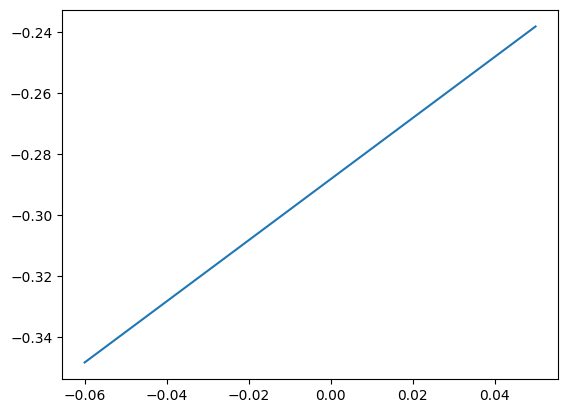

In [64]:

# Part 7

Y_val_pred_proba = model.predict_proba(X_valid)
C = (1 - (Y_val_pred_proba[:, 1] >= optimal_threshold).astype(int)) * Y_valid + 5 * (1 - Y_valid) * (Y_val_pred_proba[:, 1] >= optimal_threshold).astype(int)
variance_of_C = np.var(C)

# Bennett's Inequality
def bennett_ci(empirical_mean, variance_of_C, n, b, alpha):
    t = np.sqrt(2 * variance_of_C * np.log(1 / alpha) / n) 
    v = b * np.log(1 / alpha) / n
    print(t+v)
    return (empirical_mean - t - v, empirical_mean + t + v)

b = np.max(C)  # Upper bound of the random variable C
print(np.mean(C), variance_of_C, len(Y_valid), b, 0.01)
interval_of_C = bennett_ci(np.mean(C), variance_of_C, len(Y_valid), b, 0.01)

print(f"Empirical Variance of C: {variance_of_C:.4f}")
print(f"Confidence Interval (Bennett): {interval_of_C}")

import matplotlib.pyplot as plt
fig = plt.figure()
xs = np.array(range(-int(np.mean(C)*20),int(np.mean(C)*20)))
fs = bennett_ci(xs/100, variance_of_C, len(Y_valid), b, 0.01)[1] -np.mean(C)
plt.plot(xs/100, fs)
plt.show()

assert(type(interval_of_C) == tuple)
assert(len(interval_of_C) == 2)